In [1]:
# %pip install stable-baselines3  protobuf==3.20.*

In [2]:
# %pip install protobuf==3.20.*

In [3]:
# %pip install mss pytesseract pyautodirect

In [4]:
# %pip install PyDirectInput

In [5]:
from mss import mss
import pytesseract
import pydirectinput
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from gym import Env
from gym.spaces import Discrete, Box


In [6]:
class WebGame(Env):
    def __init__(self):
        #subclass model
        super().__init__()
        #setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1, 80,80), dtype=np.uint8)
        self.action_space = Discrete(65)
        self.cap = mss()
        self.monitor = self.cap.monitors[1]

        self.game_location = {"top": self.monitor["top"] + int(self.monitor["height"] * 0.1), "left": self.monitor["left"] + int(self.monitor["width"] * 0.25), "width": int(self.monitor["width"] * 0.5), "height": int(self.monitor["height"] * 0.8)}
        self.mon = {'top': 780, 'left': 1430, 'width': 250, 'height': 100}
        self.play_again = {'top': 878, 'left': 1560, 'width': 200, 'height': 75}



    def step(self, action):        
        action_map = {
            #right click
            0: 'dash',
            1: 'no_op',
            0: 'dash',
            1: 'no_op',
            2: (580, 258),
            3: (773, 258),
            4: (959, 258),
            5: (1145, 258),
            6: (1340, 258),
            7: (580, 540),
            8: (773, 540),
            9: (959, 540),
            10: (1145, 540),
            11: (1340, 540),
            12: (580, 822),
            13: (773, 822),
            14: (959, 822),
            15: (1145, 822),
            16: (1340, 822),
            17: (580, 258),
            18: (773, 258),
            19: (959, 258),
            20: (1145, 258),
            21: (1340, 258),
            22: (580, 540),
            23: (773, 540),
            24: (959, 540),
            25: (1145, 540),
            26: (1340, 540),
            27: (580, 822),
            28: (773, 822),
            29: (959, 822),
            30: (1145, 822),
            31: (1340, 822)
        }
        if action == 0:
            pydirectinput.click(button='left')
        elif action != 1:
            pydirectinput.moveTo(x=int(action_map[action][0]), y=int(action_map[action][1]))

        done = self.get_done()
        new_observation = self.get_observation()
        reward = 1
        info = {}
        return new_observation, reward, done, info
        
        
        
    def render(self):
        cv2.imshow('frame', np.array(self.cap.grab(self.game_location))[:, :, :3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
        
        

    def reset(self):
        #check wheter the game is over
        pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
        
        #check play again region
        while 1:
            play_again_cap = self.cap.grab(self.play_again)
            play_again = pytesseract.image_to_string(np.array(play_again_cap)[:, :, :3])
            #strip whitespace
            play_again = play_again.strip()
            
            if play_again == 'PLAY AGAIN':
                    
                # pyautogui.click(x=1640, y=919)
                pydirectinput.click(x=1640, y=919)
                time.sleep(1)
                # pyautogui.click(x=963, y=700)
                pydirectinput.click(x=963, y=700)
            return self.get_observation()
            break
            
    def get_observation(self):
        ss = self.cap.grab(self.game_location)
        raw =  np.array(ss)[:, :, :3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (80, 80))
        channel = np.reshape(resized, (1, 80, 80))        
        
        
        return channel

    
    def close(self):
        cv2.destroyAllWindows()
    
    def get_done(self):
        #CAPTURE play again region
        done_cap = np.array(self.cap.grab(self.play_again))[:, :, :3]
        done_strings = 'PLAY AGAIN'
        done = False
        res = pytesseract.image_to_string(done_cap)
        res = res.strip()
        if res == done_strings:
            done = True

        return done

In [7]:
env = WebGame()

In [8]:
#get a sample action
env.action_space.sample()

11

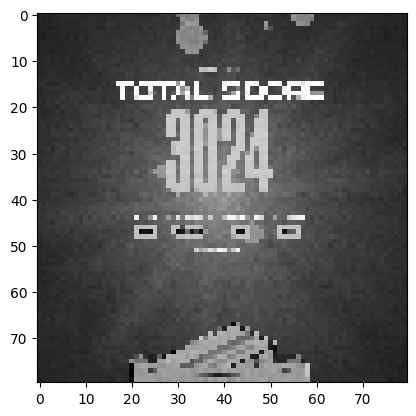

In [9]:
env.get_observation()
#matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(env.get_observation()[0], cmap='gray')

In [10]:
#CREATE A CALLBACK TO SAVE THE MODEL
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker


c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
env_checker.check_env(env)

In [12]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [13]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [14]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

## 3.2 Build DQN and Train

In [15]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [16]:
env = WebGame()

In [17]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=600000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Python310\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 7.69GB > 7.04GB
  warnings.warn(


In [18]:
model.learn(total_timesteps=50000, callback=callback)

Logging to ./logs/DQN_19
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.2     |
|    ep_rew_mean      | 46.2     |
|    exploration_rate | 0.965    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3        |
|    time_elapsed     | 58       |
|    total_timesteps  | 185      |
----------------------------------


In [ ]:
# model.load('train_first/best_mode l_50000') 

# 4. Test out Model

In [ ]:
# for episode in range(5): 
# obs = env.reset()
# done = False
# total_reward = 0
# while not done: 
#     action, _ = model.predict(obs)
#     obs, reward, done, info = env.step(int(action))
#     time.sleep(0.01)
#     total_reward += reward
# print('Total Reward for episode {} is {}'.format(episode, total_reward))
# time.sleep(2)